In [459]:
%reset -sf

In [460]:
import torch
from torch.utils.checkpoint import checkpoint
import numpy as np
from opt_einsum import contract
from tqdm.auto import tqdm

def _toN(t):
    if isinstance(t,list):
        return np.array([_toN(x) for x in t])
    else:
        return np.array(t.detach().cpu()) if isinstance(t,torch.Tensor) else np.array(t)
        
def _toT(t):
    return torch.tensor(t) if not isinstance(t,torch.Tensor) else t
torch.cuda.set_device(1)
torch.set_default_tensor_type('torch.cuda.DoubleTensor')

In [461]:
def Ising_T0(beta,h):
    beta,h=_toT(beta),_toT(h)
    a=torch.sqrt(torch.cosh(beta))
    b=torch.sqrt(torch.sinh(beta))
    c=torch.exp(beta*h)
    w=torch.stack([torch.stack([a,a]),torch.stack([b,-b])])
    z=torch.stack([c,1/c])
    return contract('iA,jA,kA,lA,A->ijkl',w,w,w,w,z)#UDLR

def Ising_SZT0(beta,h):
    beta,h=_toT(beta),_toT(h)
    a=torch.sqrt(torch.cosh(beta))
    b=torch.sqrt(torch.sinh(beta))
    c=torch.exp(beta*h)
    w=torch.stack([torch.stack([a,a]),torch.stack([b,-b])])
    z=torch.stack([c,-1/c])
    return contract('iA,jA,kA,lA,A->ijkl',w,w,w,w,z)#UDLR

R=_toT(np.diag([1.,-1.]))
T=Ising_T0(1.,0.)
print(torch.norm(contract('abcd,aA,bB,cC,dD->ABCD',T,R,R,R,R)-T))
T=Ising_SZT0(1.,0.)
print(torch.norm(contract('abcd,aA,bB,cC,dD->ABCD',T,R,R,R,R)+T))

tensor(8.1351e-16)
tensor(4.6903e-16)


In [462]:
def RepMat(dimV1R1,dimV1R2,dimV2R1,dimV2R2):
    dimV1=dimV1R1+dimV1R2
    dimV2=dimV2R1+dimV2R2
    P=torch.zeros([dimV1*dimV2,dimV1,dimV2])
    counter=0
    for i in range(dimV1R1):
        for j in range(dimV2R1):
            P[counter,i,j]=1
            counter+=1
    for i in range(dimV1R2):
        for j in range(dimV2R2):
            P[counter,dimV1R1+i,dimV2R1+j]=1
            counter+=1
    dimR1=counter
    for i in range(dimV1R1):
        for j in range(dimV2R2):
            P[counter,i,dimV2R1+j]=1
            counter+=1
    for i in range(dimV1R2):
        for j in range(dimV2R1):
            P[counter,dimV1R1+i,j]=1
            counter+=1
    dimR2=counter-dimR1
    P=P.reshape(dimV1*dimV2,-1)
    return P,dimR1,dimR2
RepMat(1,1,1,1)

(tensor([[1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.]]),
 2,
 2)

In [463]:
def HOTRG_get_w(MM,dimRn1,dimRn2,max_dim):
    MM1,MM2=MM[:dimRn1,:dimRn1],MM[dimRn1:,dimRn1:]
    S1,U1=torch.linalg.eigh(MM1)#ascending, U S Uh=MM
    S2,U2=torch.linalg.eigh(MM2)
    S,U=[S1,S2],[U1,U2]
    max_dim=min(max_dim,dimRn1+dimRn2)
    chosenEigens=sorted([(-s,0,i) for i,s in enumerate(S1)]+[(-s,1,i) for i,s in enumerate(S2)])[:max_dim]
    chosenEigens.sort(key=lambda x:x[1])
    
    shift=[0,dimRn1]
    dim=[dimRn1,dimRn2]
    dimRnn=[0,0]
    w=torch.zeros((max_dim,dimRn1+dimRn2))
    for i,(s,rep,col) in enumerate(chosenEigens):
        w[i,shift[rep]:shift[rep]+dim[rep]]=U[rep][:,col]
        dimRnn[rep]+=1
    return w,dimRnn[0],dimRnn[1]
    
    
def HOTRG(T,dimR1,dimR2,max_dim):
    P,dimRn1,dimRn2=RepMat(dimR1,dimR2,dimR1,dimR2)
    #print(dimR1,dimR2,dimRn1,dimRn2)
    MM=contract('ijkl,jmno,ipql,pmro->knqr',T,T,T.conj(),T.conj()).reshape((dimRn1+dimRn2,dimRn1+dimRn2))
    MM=P@MM@P.T.conj()
    w,dimRnn1,dimRnn2=HOTRG_get_w(MM,dimRn1,dimRn2,max_dim)
    #display(MM,w@MM@w.T.conj())
    w=(w@P).reshape(-1,dimR1+dimR2,dimR1+dimR2)
    
    Tn=contract('ijkl,jmno,akn,blo->abim',T,T,w,w.conj())
    
    #print([dimR1,dimR2],dimRnn)
    return Tn,w,dimRnn1,dimRnn2

In [464]:
def calc_isometries_HOTRG(T,dimR,max_dim,nLayers):
    #dimR[dir][rep]
    ws=[]
    logTotal=0
    for layer in range(nLayers):
        T,w,dimRn1,dimRn2=HOTRG(T,dimR[1][0],dimR[1][1],max_dim)
        dimR=[[dimRn1,dimRn2],dimR[0]]
        ws.append({'isometry':w,'multipilicity':[dimRn1,dimRn2]})
        norm=torch.linalg.norm(T)
        T=T/norm
        logTotal=2*logTotal+torch.log(norm)
    return T,logTotal,ws

T0,T0_op=Ising_T0(1.,0.),Ising_SZT0(1.,0.)
T,logTotal,ws=calc_isometries_HOTRG(T0,[[1,1],[1,1]],max_dim=4,nLayers=6)
Z=contract('aabb',T)
logTotal+=torch.log(Z)
print(Z,logTotal)

tensor(1.4141) tensor(128.7154)


In [465]:
def evolve_tensor(T,T_op,ws):
    logTotal=0
    Z,Z_op=[],[]
    for layer in range(len(ws)):
        w=ws[layer]['isometry']
        T1=contract('ijkl,jmno,akn,blo->abim',T,T,w,w.conj())
        T2=contract('ijkl,jmno,akn,blo->abim',T,T_op,w,w.conj())
        T3=contract('ijkl,jmno,akn,blo->abim',T_op,T,w,w.conj())
        norm=torch.linalg.norm(T1)
        T,T_op=T1/norm,(T2+T3)/(2*norm)
        logTotal=2*logTotal+torch.log(norm)
        Z.append(contract('aabb',T))
        Z_op.append(contract('aabb',T_op))
    return T,T_op,logTotal,Z,Z_op

T,T_op,logTotal,Z,Z_op=evolve_tensor(T0,T0_op,ws)
print(contract('aabb',T_op))
print('---')
print(contract('aabb',T))

tensor(3.3472e-15)
---
tensor(1.4141)


In [467]:
import pandas as pd
from tqdm.auto import tqdm

max_dim=4
nLayers=15

curve=pd.DataFrame()
for beta in tqdm(np.linspace(.4,.5,31)):
    with torch.no_grad():
        T0,T0_op=Ising_T0(beta,0),Ising_SZT0(beta,0)
        dimR=[[1,1],[1,1]]
        T,logTotal,ws=calc_isometries_HOTRG(T0,dimR,max_dim=max_dim,nLayers=nLayers)
        T,T_op,logTotal,Z,Z_op=evolve_tensor(T0,T0_op,ws)
        T_op_2fold=contract('ijkk,jill',T_op,T_op)
        T_2fold=contract('ijkk,jill',T,T)
        m=torch.sqrt(T_op_2fold/T_2fold)
        logZ=(logTotal+torch.log(Z[-1]))/2**nLayers
        newRow={'beta':beta,'logZ':logZ,'Z':Z,'Z_op':Z_op,'m':m,'T_op_2fold':T_op_2fold}
        newRow={k:_toN(v) for k,v in newRow.items()}
        curve=curve.append(newRow,ignore_index=True)
    


  0%|          | 0/31 [00:00<?, ?it/s]

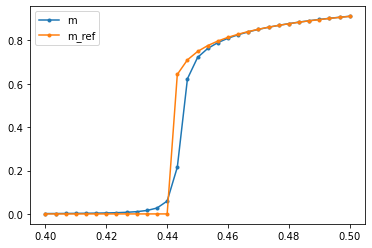

In [468]:
from IsingSolutions import Ising2DExactSolution
ising2DExactSolution=Ising2DExactSolution()
curve['logZ_ref']=ising2DExactSolution.logZ(curve['beta'])
curve['m_ref']=ising2DExactSolution.magnetization(curve['beta'])
import matplotlib.pyplot as plt
for label in ['m','m_ref']:
    plt.plot(curve['beta'],np.abs(curve[label]),'.-',label=label)
plt.legend()
plt.show()

In [469]:
可以研究的东西：各分块矩阵随trg的变化率

SyntaxError: invalid character '：' (U+FF1A) (3808757377.py, line 1)

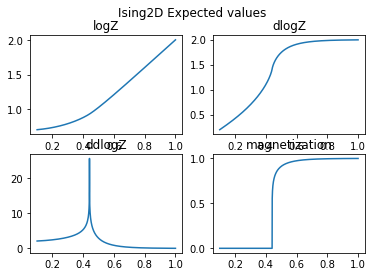

critical_beta 0.4406867935097715


In [223]:
ising2dExactSolution.display()

#### 